In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

import pickle

import string
from unidecode import unidecode
from nltk import sent_tokenize, word_tokenize, WordNetLemmatizer, pos_tag
from nltk.corpus import stopwords
# from multiprocessing import Pool

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, GlobalMaxPool1D, Bidirectional
from keras.models import Model

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
x_train = train_df['comment_text']
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat',
                    'insult', 'identity_hate']].values
x_test = test_df['comment_text']

In [3]:
sw = set(stopwords.words('english'))
wnl = WordNetLemmatizer()
num_words = 20000

In [4]:
def lemmatize_all(comment):
    """
    getting lemmatized tokens from comments
    """
    
    # removing punctuation and numbers form the comments
    comment = (unidecode(comment)
               .lower()
               .translate(str.maketrans("","", string.punctuation))
               .translate(str.maketrans("","", string.digits)))
    comment = " ".join(comment.split())
    
    # getting leematized token from the comments
    for word, tag in pos_tag(word_tokenize(comment)):
        if word not in sw:
            if tag.startswith("NN"):
                yield wnl.lemmatize(word, pos="n")
            elif tag.startswith("VB"):
                yield wnl.lemmatize(word, pos="v")
            elif tag.startswith("JJ"):
                yield wnl.lemmatize(word, pos="a")
            elif tag.startswith("R"):
                yield wnl.lemmatize(word, pos="r")
            else:
                yield word

In [5]:
def get_tokenised_x(x, train_flag=False, tokenizer=None):
    """
    getting tokens prepared further for dnn and embedding
    """
#     c = 0
    tokenized_comments = []
    for comment in x.values:
        tokenized_comments.append(" ".join(lemmatize_all(comment)))
#         print(f"\r {c}", end='')
#         c += 1
    
    if train_flag:
        tokenizer = Tokenizer(num_words=num_words)
        tokenizer.fit_on_texts(list(tokenized_comments))
        tokenizer.word_index = {k:v for k, v in tokenizer.word_index.items()
                                if v<=num_words}
        with open('tokenizer.pickle', 'wb') as f:
            pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    tokenized_x = tokenizer.texts_to_sequences(tokenized_comments)
    if train_flag:
        return tokenized_x, tokenizer
    else:
        return tokenized_x, None

In [6]:
def get_emb_matrix(word_index, emb_dim=300):
    """
    getting embedding matrix for the given dictionary of words
    from the Glove embeddings
    """
    emb_matrix = np.zeros((len(word_index)+1, emb_dim))
    with open('../../../word_embedding/glove.6B.'+str(emb_dim)+'d.txt',
              encoding='UTF8') as f:
        for l in f:
            arr = l.split()
            if arr[0] in word_index:
                emb_matrix[word_index[arr[0]]] = arr[1:]
    
    return emb_matrix

In [7]:
tokenised_x_train, tokenizer = get_tokenised_x(x_train, train_flag=True)
tokenised_x_test, _ = get_tokenised_x(x_test, train_flag=False, tokenizer=tokenizer)

In [8]:
# np.savetxt('tokenized_x_train', tokenised_x_train.astype(int), fmt='%i')
# np.savetxt('tokenized_x_test', tokenised_x_test.astype(int), fmt='%i')

In [9]:
# tokenised_x_train = np.loadtxt('tokenized_x_train', dtype=int)

In [10]:
# tokenised_x_test = np.loadtxt('tokenized_x_test', dtype=int)

In [11]:
# with open('tokenizer_word_index.pickle', 'wb') as f:
#     pickle.dump(tokenizer.word_index, f, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# with open('tokenizer_word_index.pickle', 'rb') as f:
#     tokenizer_wi = pickle.load(f)

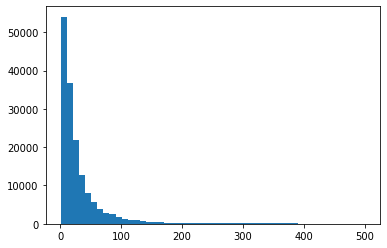

In [13]:
# for getting a good no for length of comments to be fed to the LSTM
comment_lengths = [len(comt) for comt in tokenised_x_train]
plt.hist(comment_lengths, bins=range(1, 510, 10))
plt.show()

In [14]:
# padding for getting the all the comments of equal length
maxlen = 180
tokenised_x_train = pad_sequences(tokenised_x_train, maxlen=maxlen)
tokenised_x_test = pad_sequences(tokenised_x_test, maxlen=maxlen)

In [15]:
def get_model():
    """
    Model:
    Embedding-->Bi-direct-LSTM-->MaxPool-->Dropout-->Dense-->Dropout-->Dense
    In the last dense layer, output layer, we have 6 nodes representing the 
    6 possible classes and outputting the probabilities of each of the
    comment categories
    """
    X_inp = Input((maxlen, ))
    emb_matrix = get_emb_matrix(tokenizer.word_index, 300)
#     emb_matrix = get_emb_matrix(tokenizer_wi, 300)
    X = Embedding(num_words+1, 300, weights=[emb_matrix], trainable=True)(X_inp)
    X = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(X)
    X = GlobalMaxPool1D()(X)
#     X = Dropout(0.2)(X)
    X = Dense(80, activation='relu')(X)
    X = Dropout(0.05)(X)
    X = Dense(6, activation='sigmoid')(X)
    return Model(inputs=X_inp, outputs=X)

In [16]:
# emb_matrix.shape

In [17]:
model = get_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 180, 300)          6000300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 180, 128)          186880    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                10320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 486 

In [19]:
model.fit(tokenised_x_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 2190s 15ms/step - loss: 0.0532 - acc: 0.9809 - val_loss: 0.0499 - val_acc: 0.9813
Epoch 2/2
143613/143613 [==============================] - 2219s 15ms/step - loss: 0.0407 - acc: 0.9841 - val_loss: 0.0462 - val_acc: 0.9825


In [20]:
# model.save('./trained_models/glove_variational_lstm_lemma_train_epoch_2_densenodout_valid_split_0')

In [21]:
preds = model.predict(tokenised_x_test)

In [22]:
# submission = pd.read_csv('sample_submission.csv')
# submission.set_index('id', inplace=True)
# submission[submission.columns] = preds

In [23]:
# submission.to_csv('Submission6.csv')